# Description du Projet

La propagation étendue de la COVID-19 a engendré des difficultés considérables dans les systèmes de santé, notamment en ce qui concerne le diagnostic et le dépistage des patients à un rythme soutenu. Un défi majeur dans la lutte contre la propagation de la maladie a été la rareté de tests, notamment les tests RT-PCR, qui étaient en pénurie, retardant ainsi le dépistage de nombreux cas suspects. De plus, le taux global de positivité des tests RT-PCR est estimé de 30 à 60% <sup>[4]</sup>, ce qui peut entraîner la fausse impression qu'une personne présentant des symptômes suspects est indemne.

Pour faire face à ces enjeux, les centres médicaux ont recourt à la radiographie thoracique pour le diagnostic et le suivi des patients atteints de COVID-19.

**L'objectif de ce projet est de réaliser un modèle de classification de ces radios thoraciques permettant l'aide à la détection de cas de COVID-19.**

## Caractéristiques du COVID-19 sur les radios thoraciques

Une étude <sup>[5]</sup> regroupant les informations d'une trentaine de publications dans le monde compare et liste les principales caractéristiques du COVID-19 observables sur les radiographies thoraciques ainsi que sur des tomodensitométries<sup>*</sup> thoraciques.

**Observations**

Les observations les plus fréquentes sont :
 - des **infiltrats en verre dépoli** (Ground Glass Opacity) :<br>
 Wikipédia : Aspect de halo aux limites floues, focalisé ou diffus.<br>
 L'arborescence vasculaire reste bien visible au sein de cet infiltrat.

 - Le grossissement de l’image révèle un **aspect réticulé** parsemé de très fins micronodules (ou un seul de ces aspects) :<br>
 Réticulation = quand les lignes se croisent et donnent un aspect de filet (réseau) a mailles plus ou moins larges.
 
 - le **crazy paving** fait quant à lui référence à un motif observé sur la tomodensitométrie du thorax mais qui peut également apparaître sur les radios thoraciques.
 
<br>
<span style='font-size:80%'>* : tomodensitométrie = imagerie faite à l'aide d'un produit de contraste</span>

**Distribution des observations**

Les résultats de l'étude <sup>[5]</sup> ont également montré que les observations étaient plus fréquemments faites dans la partie **périphérique bilatérale et inférieure** des poumons.

## Le dataset à notre disposition

Le modèle sera entrainé et testé sur un jeu de 21.165 radiographies thoraciques.

Ce jeu de données se compose :
 - d'images de poumons de personnes atteintes d'un COVID19 ;
 - atteintes d'une pneumonie virale ;
 - présentant une opacité pulmonaire ;
 - ou des poumons sains.
 
Nous avons également à disposition des masques d'images permettant de définir la position exacte des poumons pour chacune des radios précitées.

# Data Exploration

In [2]:
import numpy as np
import pandas as pd

# Gestion des fichiers/images
import os
from PIL import Image, ImageFilter, ImageStat

import matplotlib.pyplot  as plt
from matplotlib import style
%matplotlib inline

In [3]:
# liste des répertoires qui contiennent les datas
data_dir = {'COVID':  '../data/COVID',
            'Normal': '../data/Normal',
            'Viral Pneumonia': '../data/Viral Pneumonia',
            'Lung Opacity': '../data/Lung_Opacity'}

## Fichier des métadatas sur les images

### Métadatas fichiers "COVID"

In [4]:
df_covid = pd.read_excel('../data/COVID.metadata.xlsx', index_col=0)
display(df_covid.head(5))

,FORMAT,SIZE,URL
FILE NAME,,,
COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


### Exemple d'image

Chargement de la première image présente dans le fichier de métadatas COVID et comparaison avec les données du fichier.

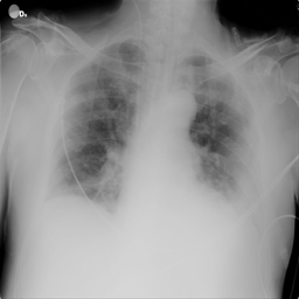

Taille de l'image : (299, 299) pixels.
Format : PNG
Mode : L (L=8 bits pixels, grayscale)


In [5]:
# Chargement de la première image en exemple
img = Image.open('../data/COVID/images/COVID-1.png')

display(img)
print (f"Taille de l'image : {img.size} pixels.")
print(f"Format : {img.format}")
print(f"Mode : {img.mode} (L=8 bits pixels, grayscale)")

**La taille de l'image ne correspond pas à ce qui est noté dans le fichier de métadatas.<br>**
De plus l'URL pointe vers l'image d'origine (des liens sont brisés) et non l'image dans le fichier data.

Nous allons donc repartir des fichiers images pour regénérer un DataFrame de métadatas.

### Création d'un DataFrame de métadatas

In [9]:
%%time
# Liste des fichiers dans un DataFrame
targets    = []
filenames  = []
files      = []
masks      = []
sizes      = []
formats    = []

# Pour chaque répertoire de données
for (target, rep) in data_dir.items():
    # Pour chaque fichier contenu dans le répertoire
    for filename in os.listdir(rep+'/images/'):
        # Teste si le fichier courant est bien un document et non un répertoire
        if os.path.isfile(os.path.join(rep+'/images/', filename)):
                
            targets.append(target)
            filenames.append(filename[:-4])
            files.append(rep+'/images/' + filename)
            masks.append(rep+'/masks/'  + filename)
            
            img = Image.open(rep+'/images/' + filename)
            sizes.append(img.size)
            formats.append(img.format)
            
# Charge les données dans un DataFrame
df = pd.DataFrame({'target':targets, 'format':formats, 'size':sizes, 'image_file':files, 'mask_file':masks}, index=filenames)

# Récupère les URL des fichiers métadatas d'origine
df_URL = pd.concat([pd.read_excel('../data/COVID.metadata.xlsx', index_col=0)['URL'],
                    pd.read_excel('../data/Normal.metadata.xlsx', index_col=0)['URL'],
                    pd.read_excel('../data/Viral_Pneumonia.metadata.xlsx', index_col=0)['URL'],
                    pd.read_excel('../data/Lung_Opacity.metadata.xlsx', index_col=0)['URL']])

# Passe les 2 index en majuscule pour éviter les différences de casse
df.index = df.index.str.upper()
df_URL.index = df_URL.index.str.upper()

# Met à jour le DataFrame df en y ajoutant l'URL
df = df.join(df_URL, how='left')

# Affiche les informations
display(df.head(3))
df.info()

KeyboardInterrupt: 

<br>
Nous allons désormais pouvoir travailler avec ce DataFrame à la place des fichiers excel.

In [10]:
df['target']

NameError: name 'df' is not defined

In [7]:
# Streamlit : 
# Sauvegarde du Dataframe pour pouvoir le recharger dans le streamlit plus rapidement
df.to_csv('../streamlit_app/assets/metadata.csv')

In [11]:
%%time
df = pd.read_csv('../data/metadata.csv')
display(df.head(3))
df.info()

,Unnamed: 0,target,format,size,image_file,mask_file,URL
0,COVID-1,COVID,PNG,"(299, 299)",../data/COVID/images/COVID-1.png,../data/COVID/masks/COVID-1.png,https://sirm.org/category/senza-categoria/covi...
1,COVID-10,COVID,PNG,"(299, 299)",../data/COVID/images/COVID-10.png,../data/COVID/masks/COVID-10.png,https://sirm.org/category/senza-categoria/covi...
2,COVID-100,COVID,PNG,"(299, 299)",../data/COVID/images/COVID-100.png,../data/COVID/masks/COVID-100.png,https://sirm.org/category/senza-categoria/covi...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  21165 non-null  object
 1   target      21165 non-null  object
 2   format      21165 non-null  object
 3   size        21165 non-null  object
 4   image_file  21165 non-null  object
 5   mask_file   21165 non-null  object
 6   URL         21165 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB
CPU times: total: 62.5 ms
Wall time: 181 ms


### Etude de la variable cible 'target'

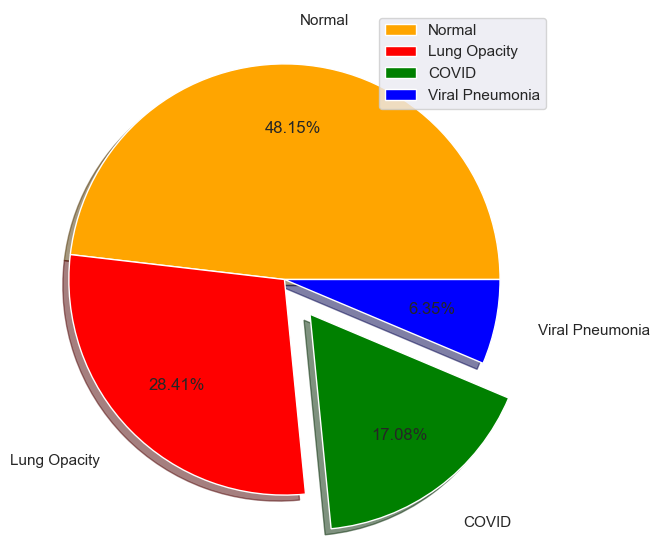

In [12]:
plt.figure(figsize = (7, 7))

counts=df["target"].value_counts()

plt.pie(x = counts, labels = counts.index,
           colors = ["orange", "red", "green", "blue", "purple"],
           explode = [0,0,0.2,0],
           autopct = lambda x: str(round(x, 2)) + '%',
           pctdistance = 0.7, labeldistance = 1.2,
           shadow = True)
plt.legend();

On observe un déséquilibre marqué dans la répartition des données, avec la classe "Normal" qui constitue la majorité, représentant près de la moitié de l'ensemble des données, soit 48%. En revanche, les classes "Covid" et "Viral Pneumonia" sont nettement minoritaires, affichant respectivement des pourcentages de 17,08% et 6,35%. Enfin pour la classe “Lung_Opacity” elle relativement importante avec un pourcentage de 28.41%. 

## Etude de la variable explicative "FORMAT"

La variable "FORMAT" une variable catégorielle, on peut faire l'analyse de sa distribution à l'aide d'un diagramme en barre.

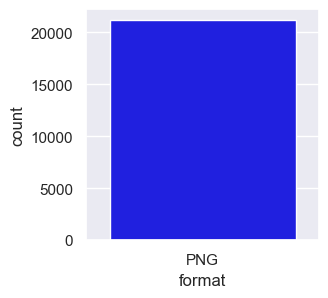

In [13]:
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(3,3))
sns.countplot(x=df["format"],color="blue");

On remarque que les images sont toutes au même format, à savoir le PNG, ce qui signifie qu'il n'est pas nécessaire de procéder à une conversion.

## Etude de la variable explicative "SIZE"

La variable "SIZE" une variable catégorielle, on peut faire l'analyse de sa distribution à l'aide d'un diagramme en barre.

<Axes: xlabel='size', ylabel='count'>

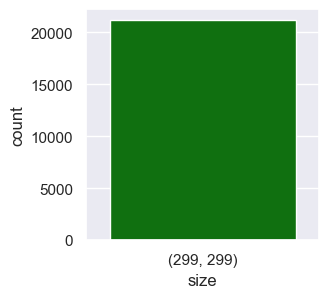

In [37]:
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(3,3))
sns.countplot(x=df["size"],color="green")

On remarque que les images sont toutes de même tailles, 299*299 pixels ce qui signifie qu'il n'est pas nécessaire de procéder à un redimensionnement.

## Etude de la variable explicative "URL"

les données ont été collectées à partir de différents ensembles de données accessibles au public, 
de sources en ligne et d'articles publiés.

La varible "URL" décrit le path d'accès à ces ressources.

Nous recherchons tout d'abord les différentes modalités de la variable "URL".

In [9]:
df["URL"].value_counts()

URL
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data                   14863
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia                       2686
https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711     2474
https://github.com/armiro/COVID-CXNet                                                400
https://eurorad.org                                                                  258
https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png            183
https://github.com/ieee8023/covid-chestxray-dataset                                  182
https://sirm.org/category/senza-categoria/covid-19/                                  119
Name: count, dtype: int64

On peut remarquer que les données étaient collectées principalement à partir des sites énumérés ci-dessous:
- Kaggle.com
- bimcv.cipf.es
- github.com
- eurorad.org
- sirm.org

Pour faciliter la représentation graphique, on peut ajouter une colonne qu'on appelle "SOURCE" ayant comme modalités les sources énumérées ci-dessus:

In [38]:
df["SOURCE"]=df["URL"].replace({'https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data': "Kaggle.com",
                                'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia':"Kaggle.com",
                                'https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711':"bimcv.cipf.es",
                                'https://github.com/armiro/COVID-CXNet':"github.com",
                                'https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png':"github.com",
                                "https://github.com/ieee8023/covid-chestxray-dataset":"github.com",
                                "https://eurorad.org":"eurorad.org",
                                "https://sirm.org/category/senza-categoria/covid-19/":"sirm.org"})

<Axes: xlabel='SOURCE', ylabel='count'>

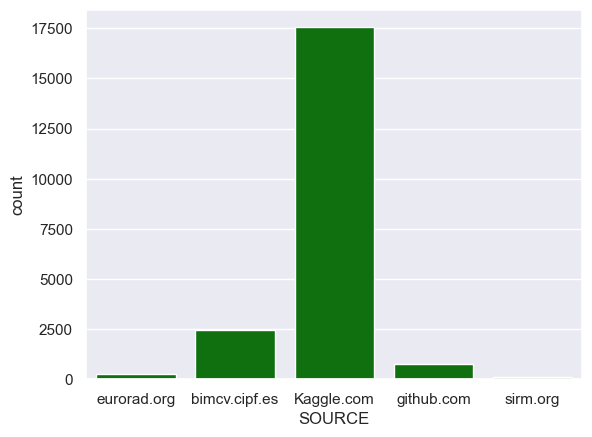

In [39]:
sns.countplot(x=df["SOURCE"],color="green")

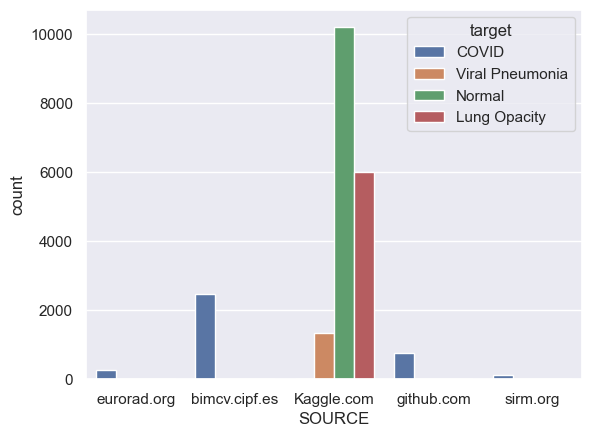

In [40]:
sns.countplot(x='SOURCE', hue='target', data=df);

Il est remarquable que la majorité des données proviennent du site "Kaggle.com", en particulier celles liées aux classes "Normal", "Viral Pneumonia" et "Lung Opacity". En revanche, les données de la classe "Covid" ont été obtenues à partir de différents sites autres que Kaggle.com (github,sirm.org,eurorad.org,bimcv.cipf.es).


## Fichiers "Masque"

A priori, les masquent permettent d'identifier où se trouvent les poumons sur la radio.<br>
Ils semblent être composés de pixels noirs et blancs uniquement.

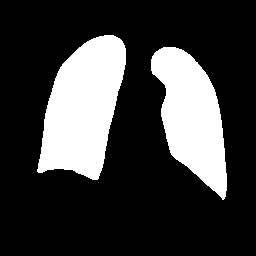

Taille de l'image : (256, 256) pixels.
Format : PNG
Mode : RGB (RGB=3x8-bit pixels, true color)
Nombre couleurs : 2
Couleurs : [  0 255]


In [13]:
# Génère une description de l'image
img_mask = Image.open(df.iloc[0]['mask_file'])
display(img_mask)
print (f"Taille de l'image : {img_mask.size} pixels.")
print(f"Format : {img_mask.format}")
print(f"Mode : {img_mask.mode} (RGB=3x8-bit pixels, true color)")

# Convertit l'image en niveaux de gris
img_mask = img_mask.convert('L')
teintes = np.unique(img_mask.getdata())
print(f"Nombre couleurs : {len(teintes)}")
print(f"Couleurs : {teintes}")

Les masques sont composés uniquement de 2 couleurs : 
- 0 : signifie que le pixel est en dehors du poumon
- 255 : signifie que le pixel est dans la zone du poumon

La taille de l'image du masque (256x256) n'est pas identique à la taille de la radio (299x299).<br>
Il faudra donc probablement redimensionner la radio si l'on souhaite appliquer le masque.

### Exemple de masque appliqué sur une image

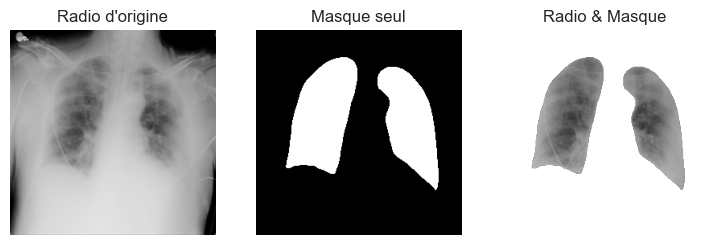

In [14]:
# Ouvre et Redimensionne l'image
img = Image.open(df.iloc[0]['image_file'])
img.thumbnail((256,256))

# Créé un nouvelle image en appliquant le masque
img_new = Image.new("RGBA", (256, 256))
img_new.paste(img, mask=img_mask)

plt.figure(figsize=(9, 3))
plt.set_cmap('gray')

ax = plt.subplot(1,3,1, title="Radio d'origine")
plt.imshow(img)
plt.axis('off')

plt.subplot(1,3,2, title="Masque seul")
plt.imshow(img_mask)
plt.axis('off')

plt.subplot(1,3,3, title="Radio & Masque")
plt.imshow(img_new)
plt.axis('off')

plt.show()

## Fichiers de radios pulmonaires

### Essais arbitraires de filtres d'images

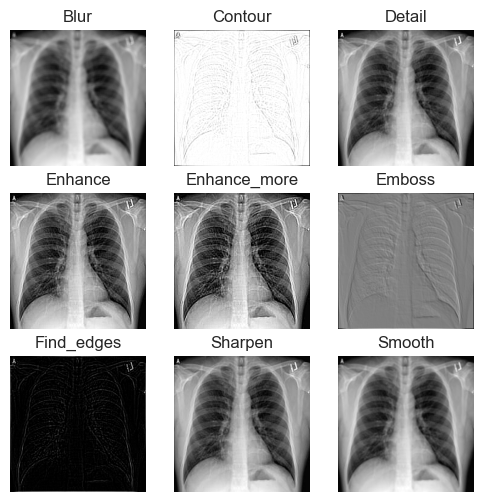

In [15]:
filters = {
'Blur': ImageFilter.BLUR,
'Contour': ImageFilter.CONTOUR,
'Detail': ImageFilter.DETAIL,
'Enhance': ImageFilter.EDGE_ENHANCE,
'Enhance_more': ImageFilter.EDGE_ENHANCE_MORE,
'Emboss': ImageFilter.EMBOSS,
'Find_edges': ImageFilter.FIND_EDGES,
'Sharpen': ImageFilter.SHARPEN,
'Smooth': ImageFilter.SMOOTH,}

img = Image.open('../data/COVID/images/COVID-232.png')

img_filtrees = {}
for name, filter in filters.items():
    img_filtrees[name] = img.filter(filter)
    
nb_rows = int(np.ceil(len(filters) / 3))

plt.figure(figsize=(6, 6))
plt.set_cmap('gray')

idx = 1
for (name, i) in img_filtrees.items():
    plt.subplot(nb_rows, 3, idx, title=name)
    plt.axis('off')
    plt.imshow(np.array(i))
    idx += 1

Les filtres peuvent être utilisés ultérieurement dans l’étape de preprocessing pour prétraiter des images et améliorer leur qualité en réduisant le bruit, en ajustant le contraste, en égalisant l'histogramme, etc. Cela permet d'obtenir des données d'entrée de meilleure qualité pour les modèles d'apprentissage automatique, ce qui peut conduire à de meilleures performances.

### Qualité des radios

#### Luminosité

La luminosité des radios semble inégale entre les différentes images.<br>
Il faudra peut-être retravailler la luminosité des radios pour pouvoir les traiter correctement.

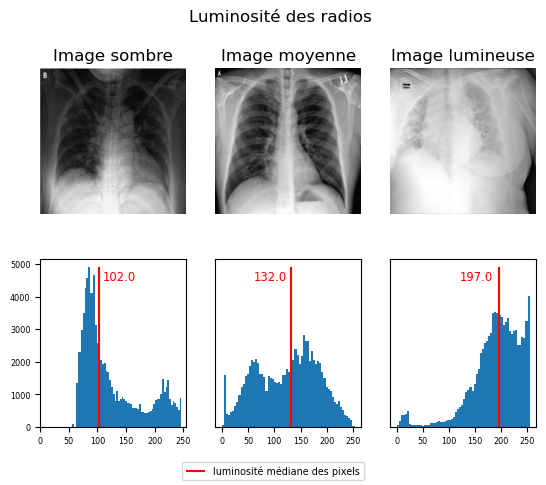

In [18]:
# Sélection de 3 images : une sombre, une équilibrée et une claire
img_sombre  = Image.open('../data/COVID/images/COVID-17.png')
img_moyenne = Image.open('../data/COVID/images/COVID-232.png')
img_claire  = Image.open('../data/COVID/images/COVID-195.png')

# Rétablit le style par défaut
style.use('default')

fig = plt.figure()
fig.suptitle('Luminosité des radios')

# Affichage des images
ax = fig.add_subplot(2,3,1, title='Image sombre')
ax.axis('off')
ax.imshow(np.asarray(img_sombre), cmap='gray')

ax = fig.add_subplot(2,3,2, title='Image moyenne')
ax.axis('off')
ax.imshow(np.asarray(img_moyenne), cmap='gray')

ax = fig.add_subplot(2,3,3, title='Image lumineuse')
ax.axis('off')
ax.imshow(np.asarray(img_claire), cmap='gray')

# Affichage des histogrammes de niveaux de gris
ax1 = fig.add_subplot(2,3,4)
ax1.hist(img_sombre.getdata(), bins=64);
ax1.axis(xmin=0, xmax=255)
ax1.tick_params(labelsize='xx-small')
m = np.median(img_sombre.getdata())
ax1.vlines(m,
          ymin=0,
          ymax=ax1.yaxis.get_data_interval()[1],
          colors='red',
          label='luminosité médiane des pixels')
plt.text(110, 4500, m, fontsize='small', color='red')

ax = fig.add_subplot(2,3,5, yticks=[])
ax.hist(img_moyenne.getdata(), bins=64);
ax.tick_params(labelsize='xx-small')
m = np.median(img_moyenne.getdata())
ax.vlines(m,
          ymin=0,
          ymax=ax1.yaxis.get_data_interval()[1],
          colors='red')
plt.text(60, 4500, m, fontsize='small', color='red')

ax = fig.add_subplot(2,3,6, yticks=[])
ax.hist(img_claire.getdata(), bins=64);
ax.tick_params(labelsize='xx-small')
m = np.median(img_claire.getdata())
ax.vlines(m,
          ymin=0,
          ymax=ax1.yaxis.get_data_interval()[1],
          colors='red')
plt.text(120, 4500, m, fontsize='small', color='red')

fig.legend(fontsize='x-small', loc='lower center');

On peut constater que pour la première image (image sombre), la majorité des pixels se situent dans la partie gauche de l'histogramme, vers les valeurs de niveaux de luminosité faibles. Inversement, les pixels de la troisième image (image claire) se concentrent dans la partie droite de l'histogramme vers les valeurs de niveaux de luminosité fortes. Par contre, pour la deuxième image (image moyenne), il y a un équilibre entre les valeurs de pixel d’où une image avec une bonne luminosité. On peut corriger ces asymétries en utilissant l’opération de normalisation d’histogramme qui permet d’étendre la plage de valeurs d’une image en étalant de manière uniforme les niveaux de gris de l’image sur tout l’intervalle de valeurs disponibles.

#### Contraste

Le niveau de contraste d'une image peut être évaluée en la transformant en niveau de gris et en calculant l'écart type des valeurs de gris des pixels.

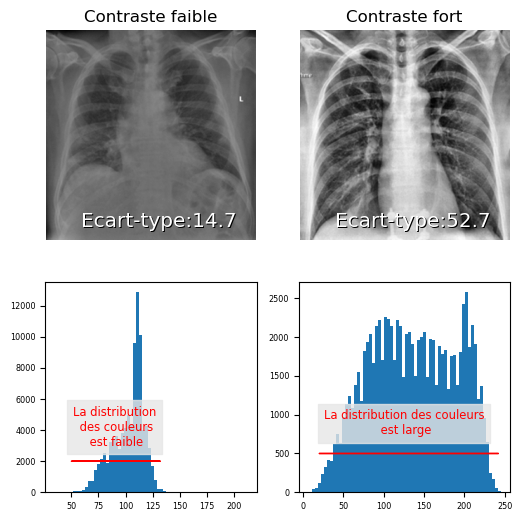

In [22]:
img_contraste_faible = Image.open('../data/COVID/images/COVID-1509.png')
img_contraste_fort   = Image.open('../data/COVID/images/COVID-1533.png')

std_faible = round(ImageStat.Stat(img_contraste_faible).stddev[0], 1)
std_fort   = round(ImageStat.Stat(img_contraste_fort).stddev[0], 1)

plt.figure(figsize=(6,6))

# Affichage des images
plt.subplot(2,2,1, title='Contraste faible')
plt.set_cmap('gray')
plt.imshow(img_contraste_faible)
plt.axis('off')
plt.text(51,281, f"Ecart-type:{std_faible}", color='black', fontsize='x-large')
plt.text(50,280, f"Ecart-type:{std_faible}", color='white', fontsize='x-large')

plt.subplot(2,2,2, title='Contraste fort')
plt.set_cmap('gray')
plt.imshow(img_contraste_fort)
plt.axis('off')
plt.text(51,281, f"Ecart-type:{std_fort}", color='black', fontsize='x-large')
plt.text(50,280, f"Ecart-type:{std_fort}", color='white', fontsize='x-large')

# Affichage de la distribution des couleurs
plt.subplot(2,2,3)
plt.hist(img_contraste_faible.getdata(), bins=64)
plt.tick_params(labelsize='xx-small')
plt.arrow(50, 2000, 80, 0, width=0.5, color='red')
plt.annotate('La distribution\n des couleurs\n est faible', (90, 2000),
             color='red',
             xytext=(90, 3000),
             fontsize='small',
             horizontalalignment='center',
             backgroundcolor=(0.9, 0.9, 0.9, 0.8))

plt.subplot(2,2,4)
plt.hist(img_contraste_fort.getdata(), bins=64)
plt.tick_params(labelsize='xx-small')
plt.arrow(20, 500, 220, 0, width=0.5, color='red')
plt.annotate('La distribution des couleurs\n est large', (125, 500),
             color='red',
             xytext=(125, 750),
             fontsize='small',
             horizontalalignment='center',
             backgroundcolor=(0.9, 0.9, 0.9, 0.8))

plt.show()

L'écart-type des couleurs des pixels permet de mesurer leur distribution. Sur l'image à contraste faible, nous voyons sur l'histogramme de gauche que le spectre des couleurs est resseré autour de la médiane. A contrario, sur l'histogramme de droite, le spectre est beaucoup plus étendu. Ce qui tend à montrer que l'image de droite aura beaucoup plus de valeurs de couleurs que l'image de gauche, et donc plus de contraste.

Un écart type plus élevé indique donc une plus grande variabilité des niveaux de gris, tandis qu'un écart type plus faible signifie une plus faible variabilité.

#### Netteté

Certaines radios ne sont pas nettes et vont devoir être retravaillées ou écartées du jeu d'apprentissage si elles le perturbent.

Les images devant toutes à peu près avoir le même type de contenu (pas de grands aplats), la netteté des radios peut être évaluée :
 - en mettant en évidence les contours contenis dans l'image (filtre)
 - puis en calculant la variance de la valeur des pixels de l'image.

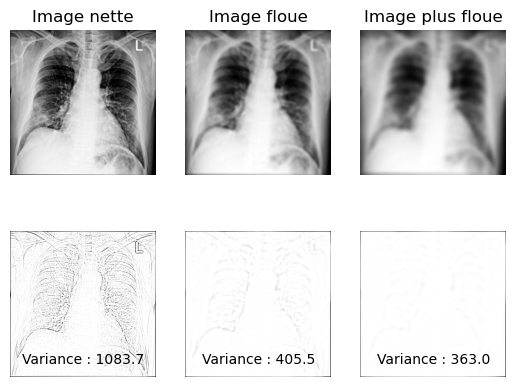

In [23]:
img = Image.open('../data/COVID/images/COVID-361.png')

# Affichage de l'image de référence
plt.subplot(2,3,1, title='Image nette')
plt.set_cmap('gray')
plt.axis('off')
plt.imshow(img)

# Affichage des contours
edges = img.filter(ImageFilter.CONTOUR)
plt.subplot(2,3,4)
plt.axis('off')
plt.imshow(edges)

# Affichage de la variance calculée sur les contours
nettete = round(np.var(edges.getdata()), 1)
plt.text(s=f"Variance : {nettete}", y=270, x=150, fontsize='medium', horizontalalignment='center')


# Affichage de l'image floue
plt.subplot(2,3,2, title='Image floue')
img_g2 = img.filter(ImageFilter.GaussianBlur(2))
plt.axis('off')
plt.imshow((img_g2))

# Affichage des contours
edges = img_g2.filter(ImageFilter.CONTOUR)
plt.subplot(2,3,5)
plt.axis('off')
plt.imshow(edges)

# Affichage de la variance calculée sur les contours
nettete = round(np.var(edges.getdata()), 1)
plt.text(s=f"Variance : {nettete}", y=270, x=150, fontsize='medium', horizontalalignment='center')


# Affichage de l'image encore plus floue
plt.subplot(2,3,3, title='Image plus floue')
img_g4 = img.filter(ImageFilter.GaussianBlur(4))
plt.axis('off')
plt.imshow(np.asarray(img_g4))

# Affichage des contours
edges = img_g4.filter(ImageFilter.CONTOUR)
plt.subplot(2,3,6)
plt.axis('off')
plt.imshow(edges)

# Affichage de la variance calculée sur les contours
nettete = round(np.var(edges.getdata()), 1)
plt.text(s=f"Variance : {nettete}", y=270, x=150, fontsize='medium', horizontalalignment='center');

#### Score total

A partir des informations mesurées ci-dessus, nous pouvons définir un score total par image.
L'objectif pour le moment est de déterminer si la qualité des images est globalement bonne ou mauvaise.

In [24]:
data_covid = '../data/COVID'

# for i in df[df['target']=='COVID'].index:
for i in df.index:

    img      = Image.open(df.loc[i, 'image_file'])
    img_mask = Image.open(df.loc[i, 'mask_file'])
    
    # Luminosité 
    df.loc[i, 'brightness'] = np.median(img.getdata())

    # Contraste
    df.loc[i, 'contrast'] = ImageStat.Stat(img).stddev[0]

    # Entropie
    # df.loc[i, 'entropy'] = img.entropy()

    # Netteté
    img.thumbnail((256,256))
    img_new = Image.new("RGBA", (256, 256))
    img_new.paste(img, mask=img_mask.convert('L'))
    edges = img_new.filter(ImageFilter.CONTOUR)
    df.loc[i, 'sharpness'] = np.var(edges.getdata())

In [25]:
# Normalisation des données
# Min-Max 
df['sharpness_score'] = (df['sharpness']-df['sharpness'].min())/(df['sharpness'].max()-df['sharpness'].min())
df['contrast_score'] = (df['contrast']-df['contrast'].min())/(df['contrast'].max()-df['contrast'].min())
# Du plus loin au plus proche de la moyenne (le contraste doit être moyen pour être bon)
df['brightness_score'] = 1 - np.abs(df['brightness']-df['brightness'].mean()) / df['brightness'].mean()

In [26]:
# Calcul du score total
df['total_score'] = df['sharpness_score'] + df['contrast_score'] + df['brightness_score']
df = df.sort_values('total_score', ascending=False)

# Récupération du top/flop radios
top  = df.head(6)['image_file']
flop = df.tail(6)['image_file']

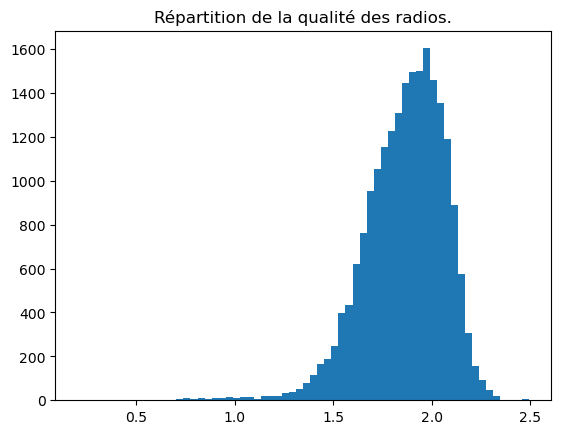

In [27]:
plt.hist(df['total_score'], bins=64);
plt.title('Répartition de la qualité des radios.')
plt.show()

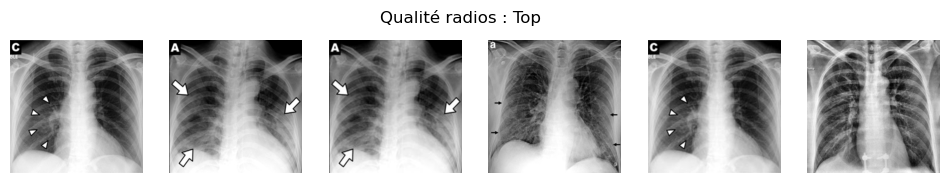

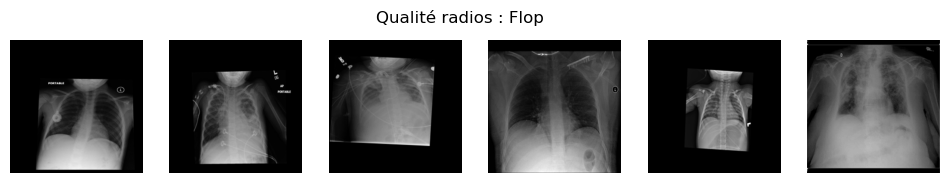

In [28]:
plt.figure(figsize=(12, 12/6))
plt.suptitle('Qualité radios : Top')
plt.set_cmap('gray')
for i, f in enumerate(top):
    plt.subplot(1, len(top), i+1)
    plt.imshow(plt.imread(f))
    plt.axis('off')
plt.show()
    
plt.figure(figsize=(12, 12/6))
plt.set_cmap('gray')
plt.suptitle('Qualité radios : Flop')
for i, f in enumerate(flop):
    plt.subplot(1, len(top), i+1)
    plt.imshow(plt.imread(f))
    plt.axis('off')
plt.show()    

## Perturbateurs d'apprentissage ou de prédiction

Une multitude de matériels (cathéters, tuyaux d'oxygène, sondes électrocardiographiques, pontages aorto-coronariens...) sont fréquemment visibles sur les radios thoraciques.<br>
Certaines radios comportent également des annotations sur la région des poumons (flèches, écriture, zones entourées...).

Leur présence sur les radios risque éventuellement perturber l'analyse des radios.

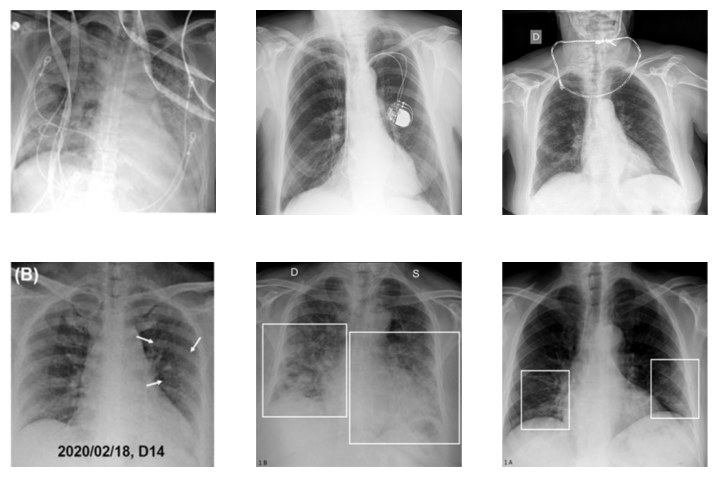

In [29]:
img_materiels1   = Image.open('../data/COVID/images/COVID-312.png')
img_materiels2   = Image.open('../data/COVID/images/COVID-1361.png')
img_materiels3   = Image.open('../data/COVID/images/COVID-1880.png')
img_annotations1 = Image.open('../data/COVID/images/COVID-168.png')
img_annotations2 = Image.open('../data/COVID/images/COVID-1837.png')
img_annotations3 = Image.open('../data/COVID/images/COVID-1841.png')

plt.figure(figsize=(9,6))
plt.set_cmap('gray')

plt.subplot(2,3,1)
plt.axis('off')
plt.imshow(img_materiels1)

plt.subplot(2,3,2)
plt.axis('off')
plt.imshow(img_materiels2)

plt.subplot(2,3,3)
plt.axis('off')
plt.imshow(img_materiels3)

plt.subplot(2,3,4)
plt.axis('off')
plt.imshow(img_annotations1)

plt.subplot(2,3,5)
plt.axis('off')
plt.imshow(img_annotations2)

plt.subplot(2,3,6)
plt.axis('off')
plt.imshow(img_annotations3)

plt.show()

### Autres cas rencontrés

Plusieurs autres cas ont été rencontrés et peuvent éventuellement perturber l'apprentissage du modèle développé :
 - Radios contenues dans un fichier images plus grand
 - Radios pivotées
 - Couleurs inversées
 
Ces cas devront peut-être être pris en compte pour éviter de perturber l'apprentissage du modèle construit.

**Note** : <br>Si les images sont retravaillées, les masques des poumons devront l'être également.

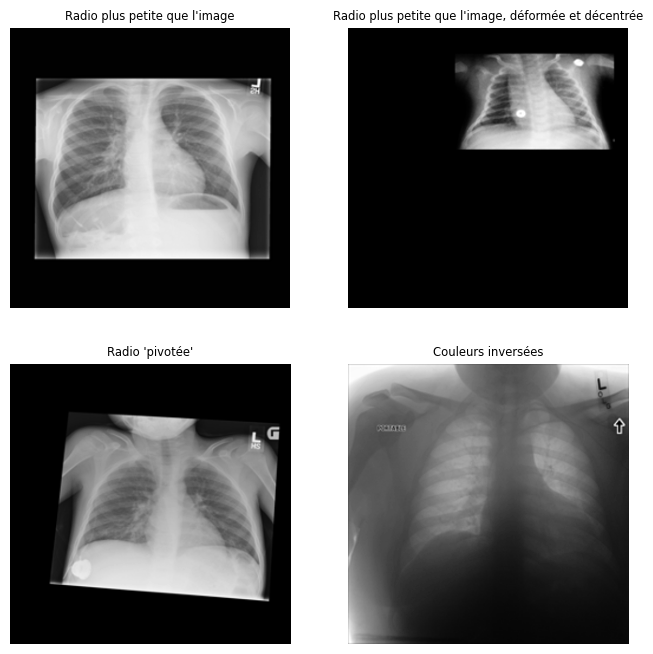

In [30]:
img_divers1 = Image.open('../data/Normal/images/Normal-10040.png')
img_divers2 = Image.open('../data/COVID/images/COVID-3615.png')
img_divers3 = Image.open('../data/Normal/images/Normal-8148.png')
img_divers4 = Image.open('../data/Normal/images/Normal-7771.png')


plt.figure(figsize=(8,8))
plt.set_cmap('gray')

plt.subplot(2,2,1)
plt.axis('off')
plt.title("Radio plus petite que l'image", fontsize='small')
plt.imshow(img_divers1)

plt.subplot(2,2,2)
plt.axis('off')
plt.title("Radio plus petite que l'image, déformée et décentrée", fontsize='small')
plt.imshow(img_divers2)

plt.subplot(2,2,3)
plt.axis('off')
plt.title("Radio 'pivotée'", fontsize='small')
plt.imshow(img_divers3)

plt.subplot(2,2,4)
plt.axis('off')
plt.title("Couleurs inversées", fontsize='small')
plt.imshow(img_divers4)

plt.show()

---
# Références

[1] - Kaggle : COVID-19 Radiography Database<br>
https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

[2] - Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, 
https://ieeexplore.ieee.org/document/9144185

[3] - Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images
Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. 
https://doi.org/10.1016/j.compbiomed.2021.104319

[4] - Classification of COVID-19 from chest x-ray images using deep features and correlation coefficient
Rahul Kumar, Ridhi Arora, Vipul Bansal, Vinodh J Sahayasheela, Himanshu Buckchash,Javed Imran, Narayanan Narayanan,Ganesh N Pandian,and Balasubramanian Raman1. 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8958819/

[5] - COVID-19 Associated Pneumonia - A review of chest radiograph and computed tomography findings
Rashid S. Al-Umairi,* Joukha Al-Kalbani, Saqar Al-Tai, Ahmed Al-Abri, Faiza Al-Kindi, and Atheel Kamona
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7968910/

